In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18, Mixed_EqResnet18
from eqCLR.test_resnet import Wide_ResNet
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2026-02-16 22:28:35.807239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-16 22:28:35.871356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 22:28:37.225803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load data and models

## Data

In [3]:
###################### PARAMS ##############################

BACKBONE = "resnet18"

BATCH_SIZE = 512
N_EPOCHS = 100 # 1000
N_CPU_WORKERS = 16
BASE_LR = 0.03         # important
WEIGHT_DECAY = 5e-4    # important
MOMENTUM = 0.9
PROJECTOR_HIDDEN_SIZE = 1024
PROJECTOR_OUTPUT_SIZE = 128
CROP_LOW_SCALE = 0.2
GRAYSCALE_PROB = 0.1   # important
PRINT_EVERY_EPOCHS = 1

In [4]:
###################### DATA LOADER #########################
transform = transforms.Compose([
        transforms.Resize((33, 33)),
        transforms.ToTensor(),
    ])

pmnist_train = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transform)
pmnist_test = PathMNIST(split='test', download=False, size=28, root='data/pathmnist/', transform=transform)

print("Data loaded.")

# additional rotation
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

transforms_ssl = transforms.Compose(
    [
        transforms.Resize((33, 33)),
        transforms.RandomResizedCrop(size=33, scale=(CROP_LOW_SCALE, 1)),
        # RandomRightAngleRotation(), # additional rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
        ),
        transforms.RandomGrayscale(p=GRAYSCALE_PROB),
        transforms.ToTensor(), # NB: runtime faster when this line is last
    ]
)

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return (self.transform(x), self.transform(x))


paired_ssl_transforms = PairedTransform(transforms_ssl)

pmnist_train_ssl = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=paired_ssl_transforms)

pmnist_loader_ssl = DataLoader(
    pmnist_train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
    pin_memory=True,
)

Data loaded.


In [5]:
inputs_test, targets_test = next(iter(pmnist_loader_ssl))  # returns a tuple (view1, view2)
inputs_test = inputs_test[0].to(device)

## Model

In [5]:
class ResNetwithProjector(nn.Module):
    def __init__(self, backbone_network, no_downsampling=False):
        super().__init__()

        self.backbone = backbone_network(weights=None)
        self.backbone_output_dim = self.backbone.fc.in_features

        if no_downsampling:
            self.backbone.conv1 = nn.Conv2d(
                3, 64, kernel_size=3, stride=1, padding=1, bias=False
            )
            self.backbone.maxpool = nn.Identity()
            
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(self.backbone_output_dim, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, PROJECTOR_OUTPUT_SIZE),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z
    
backbones = {
   "resnet18": resnet18,    # backbone_output_dim = 512
   "resnet34": resnet34,    # backbone_output_dim = 512
   "resnet50": resnet50,    # backbone_output_dim = 2048
}

### Default resnet

In [7]:
# trained with rotations, with maxpooling original image size of 28 pixels (no resize)
model_resnet18 = ResNetwithProjector(resnet18, no_downsampling=False).to(device)
model_resnet18.load_state_dict(torch.load('results/model_weights/9081-path_mnist-resnet18_with maxpool_no_resize_weights.pt', weights_only=True))

<All keys matched successfully>

In [ ]:
# trained with rotations, with maxpooling original image size of 28 pixels (resize 33)
model_resnet18 = ResNetwithProjector(resnet18, no_downsampling=False).to(device)
model_resnet18.load_state_dict(torch.load('results/model_weights/3169-path_mnist-resnet18_with_maxpool_resize33_weights.pt', weights_only=True))

In [8]:
# 1000 epochs, no downsapling
model_resnet18 = ResNetwithProjector(resnet18, no_downsampling=True).to(device)
model_resnet18.load_state_dict(torch.load('results/model_weights/9369-path_mnist-resnet18_no_maxpool_1000epochs_weights.pt', weights_only=True))

<All keys matched successfully>

In [ ]:
# 1000 epochs, downsapling
model_resnet18 = ResNetwithProjector(resnet18, no_downsampling=True).to(device)
model_resnet18.load_state_dict(torch.load('results/model_weights/1982-path_mnist-resnet18_with_maxpool_1000epochs_weights.pt', weights_only=True))

### Equivariant models

In [8]:
# default resnet architecture N=8 (resize to 33x33)
model_eq33 = EqResNet18(N=8).to(device)
model_eq33.load_state_dict(torch.load('results/model_weights/6299-path_mnist-eqCLR_N8_img_resize33_weights.pt', weights_only=True))

Make layer
Make layer
Make layer
Make layer


<All keys matched successfully>

In [ ]:
# default resnet architecture N=8 (no resize)
model_eq_w_rotation = EqResNet18(N=8).to(device)
model_eq_w_rotation.load_state_dict(torch.load('results/model_weights/1518-path_mnist-eqCLR_N8_img_no_resize_weights.pt', weights_only=True))

In [ ]:
# mixed eqresnet architecture N=8 (resize to 33x33)
model_mixed_eq33 = Mixed_EqResnet18(resnet18, N=8).to(device)
model_mixed_eq33.load_state_dict(torch.load('results/model_weights/0236-path_mnist-mixed_eqCLR_N8_resize33_weights.pt', weights_only=True))

In [ ]:
# resize, 1000 epochs with downsampling
model_eq1000 = EqResNet18(N=8).to(device)
model_eq1000.load_state_dict(torch.load('results/model_weights/6299-path_mnist-eqCLR_N8_img_resize33_weights.pt', weights_only=True))

In [9]:
def infoNCE(features, temperature=0.5):
    x = F.normalize(features)
    cos_xx = x @ x.T / temperature
    cos_xx.fill_diagonal_(float("-inf"))
    
    batch_size = cos_xx.size(0) // 2
    targets = torch.arange(batch_size * 2, dtype=int, device=cos_xx.device)
    targets[:batch_size] += batch_size
    targets[batch_size:] -= batch_size

    return F.cross_entropy(cos_xx, targets)


In [83]:
import torch.profiler

targets_test = torch.zeros(inputs_test.size(0), dtype=torch.long, device=device)  # dummy labels if needed

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    output = model_eq33(inputs_test)
    # if you want backward profiling:
    _, z1 = model_eq33(inputs_test)
    _, z2 = model_eq33(inputs_test)
    loss = infoNCE(torch.cat((z1, z2)))    
    loss.backward()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
autograd::engine::evaluate_function: ConvolutionBack...         0.02%       1.035ms        21.32%        1.390s      34.759ms       0.000us         0.00%     408.356ms      10.209ms           0 B           0 B      -1.17 GB      -8.47 G

In [10]:
import torch.profiler

targets_test = torch.zeros(inputs_test.size(0), dtype=torch.long, device=device)  # dummy labels if needed

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    output = model_resnet18(inputs_test)
    # if you want backward profiling:
    _, z1 = model_resnet18(inputs_test)
    _, z2 = model_resnet18(inputs_test)
    loss = infoNCE(torch.cat((z1, z2)))    
    loss.backward()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
autograd::engine::evaluate_function: ConvolutionBack...         0.02%       1.565ms        23.46%        2.230s      55.745ms       0.000us         0.00%      14.329ms     358.230us           0 B           0 B    -137.03 MB    -483.10 M

# Evaluation

In [4]:
# SimCLR
with open('results/model_eval/9081-path_mnist-resnet18_with maxpool_no_resize_eval.pkl', 'rb') as f:
    eval_dict_resnet18 = pickle.load(f)

# SimCLR resize 33
with open('results/model_eval/3169-path_mnist-resnet18_with_maxpool_resize33_eval.pkl', 'rb') as f:
    eval_dict_resnet18_33 = pickle.load(f)

# EqCLR resize 33
with open('results/model_eval/6299-path_mnist-eqCLR_N8_img_resize33_2_eval.pkl', 'rb') as f:
    eval_dict_eq33 = pickle.load(f)

# EqCLR no resize
with open('results/model_eval/1518-path_mnist-eqCLR_N8_img_no_resize_2_eval.pkl', 'rb') as f:
    eval_dict_eq28 = pickle.load(f)

# Mixed EqCLR with resize 33
with open('results/model_eval/0236-path_mnist-mixed_eqCLR_N8_resize33_eval.pkl', 'rb') as f:
    eval_dict_mixed_eq33 = pickle.load(f)

In [5]:
import pandas as pd

models = {
    "eqResnet18_33": eval_dict_eq33,
    "eqResnet18_28": eval_dict_eq28,
    "mixed_eqResnet18_33": eval_dict_mixed_eq33,
    "Resnet18": eval_dict_resnet18,
    "Resnet18_33": eval_dict_resnet18_33,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df = pd.DataFrame(eval_dict_all).T

display(evals_df)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
eqResnet18_33,0.895682,0.894011,0.901671,0.899721,0.899164
eqResnet18_28,0.886351,0.878691,0.893175,0.892479,0.884401
mixed_eqResnet18_33,0.830501,0.834540,0.847632,0.847911,0.822563
Resnet18,0.826323,0.824930,0.831894,0.834262,0.817270
Resnet18_33,0.828830,0.828830,0.837604,0.836351,0.826184


# Equivariance check

It must hold:
\begin{align}
f(Rx) = R(f(x))
\end{align}

In [3]:
# Load results
import pickle

# Resnet18
with open('results/model_eval_rotations/9081-path_mnist-resnet18_with maxpool_no_resize_rotation_eval.pkl', 'rb') as f:
    resnet18_rot_eval = pickle.load(f)
resnet18_eq_errors = resnet18_rot_eval['Eq_errors']
resnet18_rot_consistency = resnet18_rot_eval['Pred_consistency']

# eqResnet33
with open('results/model_eval_rotations/6299-path_mnist-eqCLR_N8_img_resize33_2_rotation_eval.pkl', 'rb') as f:
    eqresnet33_rot_eval = pickle.load(f)
eqresnet33_eq_errors = eqresnet33_rot_eval['Eq_errors']
eqresnet33_rot_consistency = eqresnet33_rot_eval['Pred_consistency']

# eqResnet28
with open('results/model_eval_rotations/1518-path_mnist-eqCLR_N8_img_no_resize_2_rotation_eval.pkl', 'rb') as f:
    eqresnet28_rot_eval = pickle.load(f)
eqresnet28_eq_errors = eqresnet28_rot_eval['Eq_errors']
eqresnet28_rot_consistency = eqresnet28_rot_eval['Pred_consistency']

# Mixed eqResnet33
with open('results/model_eval_rotations/0236-path_mnist-mixed_eqCLR_N8_resize33_rotation_eval.pkl', 'rb') as f:
    mixedeqresnet33_rot_eval = pickle.load(f)
mixedeqresnet33_eq_errors = mixedeqresnet33_rot_eval['Eq_errors']
mixedeqresnet33_rot_consistency = mixedeqresnet33_rot_eval['Pred_consistency']

In [4]:
import pandas as pd
# Resnet18
errors_df_resnet = pd.DataFrame.from_dict(resnet18_eq_errors, orient='index')
errors_df_resnet['mean_error'] = errors_df_resnet.iloc[:,1:].mean(axis=1)
errors_df_resnet = errors_df_resnet[~errors_df_resnet.index.str.contains("downsample")]
display(errors_df_resnet)

# mean per column
print(errors_df_resnet.mean(axis=0))

resnet_layers = errors_df_resnet.index.tolist()
resnet_layers = [name.replace('backbone.', '', 1) for name in resnet_layers]
resnet_layers_means = errors_df_resnet['mean_error'].tolist()
print(resnet_layers)

,0,90,180,270,mean_error
backbone.conv1,0.0,0.607260,0.636982,0.616844,0.620362
backbone.layer1.0.conv1,0.0,0.367481,0.405525,0.368456,0.380487
backbone.layer1.0.conv2,0.0,0.297676,0.334771,0.298017,0.310155
backbone.layer1.1.conv1,0.0,0.385654,0.422048,0.385325,0.397676
backbone.layer1.1.conv2,0.0,0.260155,0.298931,0.261768,0.273618
backbone.layer2.0.conv1,0.0,0.220202,0.252770,0.219650,0.230874
backbone.layer2.0.conv2,0.0,0.207195,0.234321,0.207612,0.216376
backbone.layer2.1.conv1,0.0,0.156110,0.187165,0.155550,0.166275
backbone.layer2.1.conv2,0.0,0.108334,0.124808,0.108354,0.113832
backbone.layer3.0.conv1,0.0,0.114623,0.126519,0.110123,0.117088


0             0.000000
90            0.174278
180           0.193337
270           0.174651
mean_error    0.180755
dtype: float32
['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


In [5]:
keep_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 
                'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 
                'layer1.0.bn2', 'layer1.1.conv1', 'layer1.1.bn1', 
                'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 
                'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 
                'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 
                'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 
                'layer2.1.conv2', 'layer2.1.bn2', 'layer3.0.conv1', 
                'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 
                'layer3.0.bn2', 'layer3.0.downsample', 'layer3.1.conv1', 
                'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 
                'layer3.1.bn2', 'layer4.0.conv1', 'layer4.0.bn1', 
                'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 
                'layer4.0.downsample', 'layer4.1.conv1', 'layer4.1.bn1', 
                'layer4.1.relu', 'layer4.1.conv2', 'layer4.1.bn2', 'gpool']

In [6]:
# eqResnet33
errors_df_eq_resnet33 = pd.DataFrame.from_dict(eqresnet33_eq_errors, orient='index')
errors_df_eq_resnet33['mean_error'] = errors_df_eq_resnet33.iloc[:,1:].mean(axis=1)
display(errors_df_eq_resnet33)

errors_df_eq_resnet33_filt = errors_df_eq_resnet33[errors_df_eq_resnet33.index.isin(keep_layers)]
eq_resnet33_layer_means = errors_df_eq_resnet33_filt['mean_error'].tolist()

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,4.948011e-08,5.211397e-08,4.943974e-08,5.034461e-08
bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
relu,8.325057e-17,8.393024e-17,9.987004e-17,1.084286e-16,9.740964e-17
maxpool,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1,8.750908e-17,1.748224e-05,1.911870e-05,1.884283e-05,1.848126e-05
layer1.0,9.373161e-17,5.737583e-06,5.755402e-06,5.363688e-06,5.618891e-06
layer1.0.conv1,0.000000e+00,6.648021e-07,7.156150e-07,6.656546e-07,6.820239e-07
layer1.0.bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1.0.relu,8.322486e-17,8.369860e-17,9.958645e-17,1.088284e-16,9.737116e-17
layer1.0.conv2,0.000000e+00,4.923387e-07,5.530547e-07,4.895626e-07,5.116520e-07


In [7]:
# eqResnet28
errors_df_eq_resnet28 = pd.DataFrame.from_dict(eqresnet28_eq_errors, orient='index')
errors_df_eq_resnet28['mean_error'] = errors_df_eq_resnet28.iloc[:,1:].mean(axis=1)
display(errors_df_eq_resnet28)

errors_df_eq_resnet28_filt = errors_df_eq_resnet28[errors_df_eq_resnet28.index.isin(keep_layers)]
eq_resnet28_layer_means = errors_df_eq_resnet28_filt['mean_error'].tolist()

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,2.080788e-01,2.581947e-01,2.055487e-01,2.239407e-01
bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
relu,8.304553e-17,8.392328e-17,9.976450e-17,1.084208e-16,9.736951e-17
maxpool,0.000000e+00,2.693757e-01,4.217900e-01,2.700557e-01,3.204071e-01
layer1,8.039820e-17,1.852429e-05,1.801343e-05,1.553552e-05,1.735774e-05
layer1.0,9.126969e-17,5.164398e-06,5.228304e-06,4.684565e-06,5.025755e-06
layer1.0.conv1,0.000000e+00,6.513441e-07,7.330441e-07,6.506284e-07,6.783389e-07
layer1.0.bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1.0.relu,8.268501e-17,8.432395e-17,1.006932e-16,1.093743e-16,9.813048e-17
layer1.0.conv2,0.000000e+00,5.623249e-07,6.349096e-07,5.625781e-07,5.866042e-07


In [8]:
# mixed eqresnet architecture N=8 (resize to 33x33)
errors_df_mixed_eq33 = pd.DataFrame.from_dict(mixedeqresnet33_eq_errors, orient='index')
errors_df_mixed_eq33['mean_error'] = errors_df_mixed_eq33.iloc[:,1:].mean(axis=1)
display(errors_df_mixed_eq33)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,5.782147e-08,6.134713e-08,5.774469e-08,5.897110e-08
bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
relu,8.264089e-17,8.374371e-17,9.945347e-17,1.079273e-16,9.704147e-17
gpool,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Plot

['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


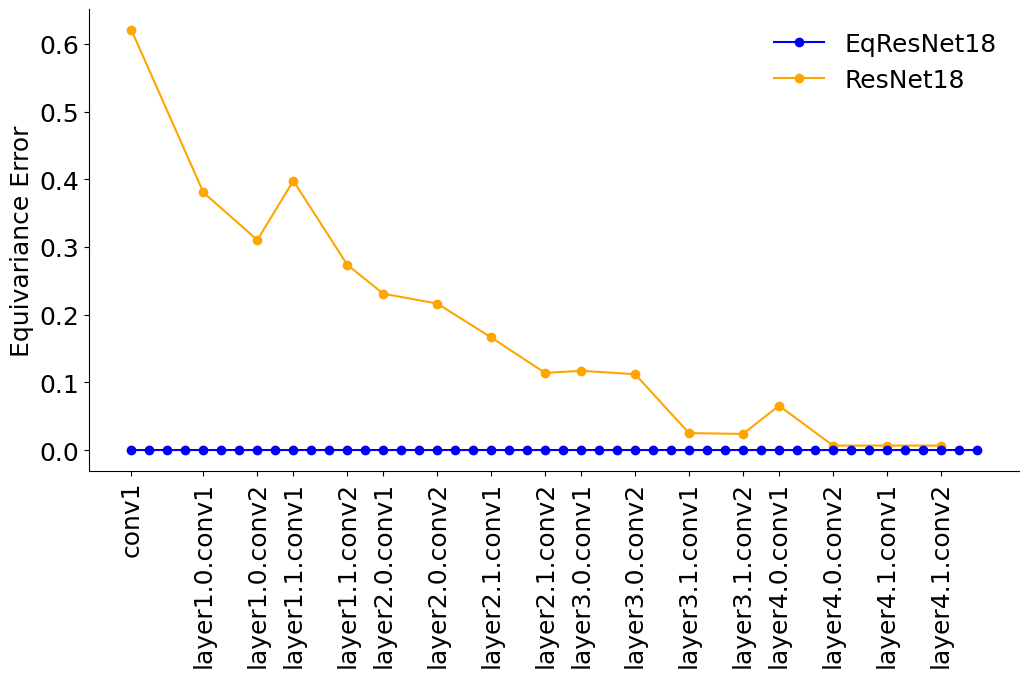

In [13]:
import matplotlib.pyplot as plt

x_ticks = [name for name in keep_layers if 'conv' in name]
print(x_ticks)
font = 18

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(keep_layers, eq_resnet33_layer_means, label='EqResNet18', marker='o', color='blue', zorder=10)
#ax.plot(keep_layers, eq_resnet28_layer_means, label='EqResNet18_28', marker='o', color='lightsteelblue', zorder=5)
ax.plot(resnet_layers, resnet_layers_means, label='ResNet18', marker='o', color='orange')

# Set x-ticks
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=90, fontsize=font)
ax.tick_params(axis='y', labelsize=font) 

# # ticks for big error
# for name, val in zip(keep_layers, eq_resnet28_layer_means):
#     if val > 0.05 and name not in x_ticks:
#         ax.annotate(name, (name, val), textcoords="offset points", xytext=(0,10), ha='center', color='lightsteelblue', fontsize=font-2)

ax.legend(frameon=False, fontsize=font)
ax.set_ylabel('Equivariance Error', fontsize=font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [31]:
# load pickle files for rotation evaluation
with open('results/model_eval_rotations/6253-path_mnist-eqCLR_N8_resize33_with_maxpool_frac1.0_rotation_eval.pkl', 'rb') as f:
    eq_rot = pickle.load(f)

with open('results/model_eval_rotations/2109-path_mnist-resnet18_frac1.0_rotation_eval.pkl', 'rb') as f:
    res_rot = pickle.load(f)
# results/model_eval_rotations/3177-path_mnist-eqCLR_N8_resize33_1000epochs_v2_rotation_eval.pkl

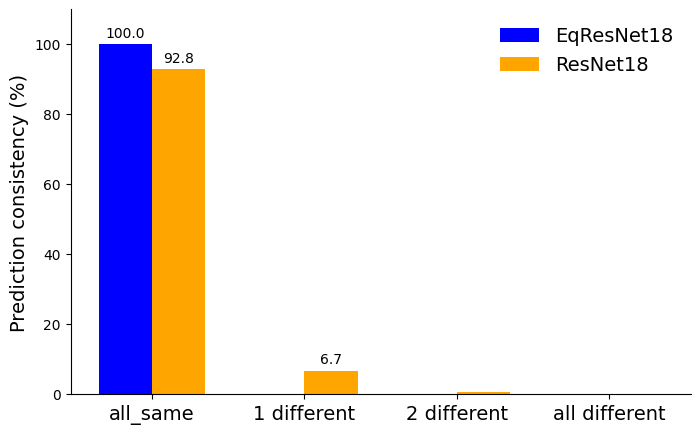

In [37]:
categories = list(eq_rot['Pred_consistency'].keys())
values1 = list(eq_rot['Pred_consistency'].values())
values2 = list(res_rot['Pred_consistency'].values())

x = np.arange(len(categories))  # the label locations
width = 0.35  # width of the bars
font = 14

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, values1, width, label='EqResNet18', color='blue')
rects2 = ax.bar(x + width/2, values2, width, label='ResNet18', color='orange')

for rect in rects1:
    height = rect.get_height()
    if height > 5:
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # small vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    if height > 5:
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        
# Labels and title
ax.set_ylabel('Prediction consistency (%)', fontsize=font)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=font)
ax.set_ylim(0, 110)
ax.legend(fontsize=font, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [33]:
res_rot['Pred_consistency']

{'all_same': 92.8133704735376,
 '1 different': 6.671309192200557,
 '2 different': 0.5153203342618384,
 'all different': 0.0}

# test

In [19]:
from escnn.nn import EquivariantModule
from rotation_eval import pred_consistency_90deg, check_equivariance_90deg

EquivariantModule.check_equivariance_90deg = check_equivariance_90deg

# Equivariance error per layer
eqresnet33_eq_errors2 = {}

for name, module in model_eq33.named_modules():
    if isinstance(module, EquivariantModule):
        error = module.check_equivariance_90deg()
        eqresnet33_eq_errors2[name] = error

⚠ WARNING: Error for element 2[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 2[2pi/8]: max=0.000094, mean=0.000005, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000146, mean=0.000004, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000113, mean=0.000005, var=0.000000
⚠ WARNING: Error for element 2[2pi/8]: max=0.000034, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000037, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000044, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 2[2pi/8]: max=0.000044, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000050, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000050, mean=0.000001, var=0.000000
⚠ WARNING: Error for element

In [20]:
# eqResnet33_2
errors_df_eq_resnet33_2 = pd.DataFrame.from_dict(eqresnet33_eq_errors2, orient='index')
errors_df_eq_resnet33_2['mean_error'] = errors_df_eq_resnet33_2.iloc[:,1:].mean(axis=1)
errors_df_eq_resnet33_2 = errors_df_eq_resnet33_2[~errors_df_eq_resnet33_2.index.str.contains("downsample")]
display(errors_df_eq_resnet33_2)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,4.006883e-08,4.226733e-08,3.994415e-08,4.076010e-08
bn1,0.000000e+00,1.296850e-09,1.775961e-09,1.208293e-09,1.427034e-09
relu,8.345175e-17,8.443490e-17,1.002370e-16,1.088613e-16,9.784442e-17
maxpool,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1,6.093370e-17,4.695728e-06,4.413655e-06,4.640213e-06,4.583198e-06
layer1.0,8.337431e-17,9.673278e-07,1.004917e-06,1.036139e-06,1.002795e-06
layer1.0.conv1,0.000000e+00,6.642503e-07,6.854181e-07,6.638948e-07,6.711877e-07
layer1.0.bn1,0.000000e+00,4.932278e-10,8.393994e-10,1.416302e-09,9.163099e-10
layer1.0.relu,8.259927e-17,8.380578e-17,9.989598e-17,1.085077e-16,9.740315e-17
layer1.0.conv2,0.000000e+00,4.814938e-07,5.235859e-07,4.806012e-07,4.952269e-07


## Default Resnet

In [22]:
model_eq33.to(device)

EqResNet18(
  (conv1): R2Conv([C8_on_R2[(None, 8)]: {irrep_0 (x3)}(3)], [C8_on_R2[(None, 8)]: {regular (x64)}(512)], kernel_size=7, stride=2, padding=3)
  (bn1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x64)}(512)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=False, type=[C8_on_R2[(None, 8)]: {regular (x64)}(512)])
  (maxpool): PointwiseMaxPool2D()
  (layer1): SequentialModule(
    (0): EqBasicBlock(
      (conv1): R2Conv([C8_on_R2[(None, 8)]: {regular (x64)}(512)], [C8_on_R2[(None, 8)]: {regular (x64)}(512)], kernel_size=3, stride=1, padding=1, bias=False)
      (bn1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x64)}(512)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=False, type=[C8_on_R2[(None, 8)]: {regular (x64)}(512)])
      (conv2): R2Conv([C8_on_R2[(None, 8)]: {regular (x64)}(512)], [C8_on_R2[(None, 8)]: {regular (x64)}(512)], kernel_size=3, stride=1, padding=1, bias=False)
      

In [27]:
def register_shape_hooks(model):
    hooks = []

    def hook_fn(module, inp, out):
        class_name = module.__class__.__name__
        input_shape = tuple(inp[0].shape)
        output_shape = tuple(out.shape) if torch.is_tensor(out) else None
        print(f"{class_name}: input {input_shape} -> output {output_shape}")

    for name, module in model.named_modules():
        if isinstance(module, EquivariantModule) and not re.fullmatch(r'layer\d+(\.\d+)?', name):
            hooks.append(module.register_forward_hook(hook_fn))

    return hooks

model_eq33.eval()
x = torch.randn(1, 3, 33, 33).to(device)

hooks = register_shape_hooks(model_eq33)
with torch.no_grad():
    model_eq33(x)
    
for h in hooks:
    h.remove()

R2Conv: input (1, 3, 33, 33) -> output None
R2Conv: input (1, 3, 33, 33) -> output None
R2Conv: input (1, 3, 33, 33) -> output None
R2Conv: input (1, 3, 33, 33) -> output None
BatchNorm3d: input (1, 64, 8, 17, 17) -> output (1, 64, 8, 17, 17)
BatchNorm3d: input (1, 64, 8, 17, 17) -> output (1, 64, 8, 17, 17)
InnerBatchNorm: input (1, 512, 17, 17) -> output None
InnerBatchNorm: input (1, 512, 17, 17) -> output None
InnerBatchNorm: input (1, 512, 17, 17) -> output None
InnerBatchNorm: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
R2Conv: input (1, 512, 9, 9) -> output None
R2Conv: input (1, 512,

In [34]:
named_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 
                'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 
                'layer1.0.bn2', 'layer1.1.conv1', 'layer1.1.bn1', 
                'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 
                'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 
                'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 
                'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 
                'layer2.1.conv2', 'layer2.1.bn2', 'layer3.0.conv1', 
                'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 
                'layer3.0.bn2', 'layer3.0.downsample', 'layer3.1.conv1', 
                'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 
                'layer3.1.bn2', 'layer4.0.conv1', 'layer4.0.bn1', 
                'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 
                'layer4.0.downsample', 'layer4.1.conv1', 'layer4.1.bn1', 
                'layer4.1.relu', 'layer4.1.conv2', 'layer4.1.bn2', 'gpool']

In [43]:
import torch

input_sizes = {}

def hook_fn(name):
    def hook(module, inp, out):
        # Store input shape of this layer
        input_sizes[name] = tuple(inp[0].shape)
    return hook

hooks = []
for name, module in model_eq33.named_modules():
    hooks.append(module.register_forward_hook(hook_fn(name)))

x = torch.randn(1, 3, 33, 33).to(device) 
model_eq33.eval()
with torch.no_grad():
    model_eq33(x)

for h in hooks:
    h.remove()


R2Conv: input (1, 3, 33, 33) -> output None
R2Conv: input (1, 3, 33, 33) -> output None
R2Conv: input (1, 3, 33, 33) -> output None
BatchNorm3d: input (1, 64, 8, 17, 17) -> output (1, 64, 8, 17, 17)
BatchNorm3d: input (1, 64, 8, 17, 17) -> output (1, 64, 8, 17, 17)
InnerBatchNorm: input (1, 512, 17, 17) -> output None
InnerBatchNorm: input (1, 512, 17, 17) -> output None
InnerBatchNorm: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
ReLU: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
PointwiseMaxPool2D: input (1, 512, 17, 17) -> output None
R2Conv: input (1, 512, 9, 9) -> output None
R2Conv: input (1, 512, 9, 9) -> output None
R2Conv: input (1, 512, 9, 9) -> output None
BatchNorm3d: input (1, 64, 8, 9, 9) -> output (1, 64, 8, 9, 9)
BatchNorm3d: input (1, 64, 8, 9, 9) -> output (1, 64, 8, 9, 9)
InnerBat

In [51]:
# eqResnet N8

# Equivariance error per layer
eqresnet33_eq_errors3 = {}

for name, module in model_eq33.named_modules():
    if isinstance(module, EquivariantModule):
        size = input_sizes.get(name)[-1]
        error = module.check_equivariance_90deg(x_size=size)
        eqresnet33_eq_errors3[name] = error

R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
⚠ WARNING: Error for element 2[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
R2Conv: input (3, 3, 33, 33) -> output None
⚠ WARNING: Error for element 4[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
R2Conv: input (3, 3, 33, 33) -> output None
R2

In [50]:
errors_df_eq_resnet33_3 = pd.DataFrame.from_dict(eqresnet33_eq_errors3, orient='index')
errors_df_eq_resnet33_3['mean_error'] = errors_df_eq_resnet33_3.iloc[:,1:].mean(axis=1)
errors_df_eq_resnet33_3 = errors_df_eq_resnet33_3[~errors_df_eq_resnet33_3.index.str.contains("downsample")]
display(errors_df_eq_resnet33_3)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,4.996253e-08,5.262612e-08,4.968753e-08,5.075873e-08
bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
relu,8.245133e-17,8.372170e-17,9.927988e-17,1.080415e-16,9.701436e-17
maxpool,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1,7.977596e-17,1.650423e-08,2.033198e-08,1.954469e-08,1.879363e-08
layer1.0,8.191476e-17,2.566936e-08,2.407474e-08,2.750139e-08,2.574850e-08
layer1.0.conv1,0.000000e+00,6.629296e-07,7.090744e-07,6.614544e-07,6.778194e-07
layer1.0.bn1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1.0.relu,8.362211e-17,8.444149e-17,1.001043e-16,1.092829e-16,9.794290e-17
layer1.0.conv2,0.000000e+00,4.874857e-07,5.560370e-07,4.863805e-07,5.099677e-07


In [59]:
import torch

input_sizes_res = {}

def hook_fn(name):
    def hook(module, inp, out):
        # Store input shape of this layer
        input_sizes_res[name] = tuple(inp[0].shape)
    return hook

hooks_res = []
for name, module in model_resnet18.named_modules():
    hooks_res.append(module.register_forward_hook(hook_fn(name)))

x = torch.randn(1, 3, 33, 33).to(device) 
model_resnet18.eval()
with torch.no_grad():
    model_resnet18(x)

for h in hooks_res:
    h.remove()


# Rotation invariance

In [10]:
consistencies = {
    'eqResnet18_33': eqresnet33_rot_consistency,
    'eqResnet18_28': eqresnet28_rot_consistency,
    'mixed_eqResnet18_33': mixedeqresnet33_rot_consistency,
    'Resnet18': resnet18_rot_consistency,
}

consistencies_df = pd.DataFrame(consistencies).T
display(consistencies_df)

,all_same,1 different,2 different,all different
eqResnet18_33,100.000000,0.000000,0.000000,0.000000
eqResnet18_28,91.532033,8.036212,0.431755,0.000000
mixed_eqResnet18_33,91.183844,8.467967,0.320334,0.027855
Resnet18,84.791086,13.690808,1.518106,0.000000


# Training KNN development

In [7]:
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)


In [8]:
# SimCLR
with open('results/model_details/9081-path_mnist-resnet18_with maxpool_no_resize_details.pkl', 'rb') as f:
    details_resnet18 = pickle.load(f)

# EqCLR resize 33
with open('results/model_details/6299-path_mnist-eqCLR_N8_img_resize33_details.pkl', 'rb') as f:
    details_eq33 = pickle.load(f)

# EqCLR no resize
with open('results/model_details/1518-path_mnist-eqCLR_N8_img_no_resize_details.pkl', 'rb') as f:
    details_eq28 = pickle.load(f)

# Mixed EqCLR with resize 33
with open('results/model_details/0236-path_mnist-mixed_eqCLR_N8_resize33_details.pkl', 'rb') as f:
    details_mixed_eq33 = pickle.load(f)

In [49]:
details_eq33['Model structure']

'EqResNet18(\n  (conv1): R2Conv([C8_on_R2[(None, 8)]: {irrep_0 (x3)}(3)], [C8_on_R2[(None, 8)]: {regular (x64)}(512)], kernel_size=7, stride=2, padding=3)\n  (bn1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x64)}(512)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU(inplace=False, type=[C8_on_R2[(None, 8)]: {regular (x64)}(512)])\n  (maxpool): PointwiseMaxPool2D()\n  (layer1): SequentialModule(\n    (0): EqBasicBlock(\n      (conv1): R2Conv([C8_on_R2[(None, 8)]: {regular (x64)}(512)], [C8_on_R2[(None, 8)]: {regular (x64)}(512)], kernel_size=3, stride=1, padding=1, bias=False)\n      (bn1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x64)}(512)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU(inplace=False, type=[C8_on_R2[(None, 8)]: {regular (x64)}(512)])\n      (conv2): R2Conv([C8_on_R2[(None, 8)]: {regular (x64)}(512)], [C8_on_R2[(None, 8)]: {regular (x64)}(512)], kernel_size=3, stride=1, padding=1, bias=Fa

In [20]:
KNN_training = {
    "Resnet18": np.array(list(details_resnet18['KNN during training'].values())),
    "eqResnet18_33": np.array(list(details_eq33['KNN during training'].values())),
    "eqResnet18_28": np.array(list(details_eq28['KNN during training'].values())),
    "mixed_eqResnet18_33": np.array(list(details_mixed_eq33['KNN during training'].values())),
}


In [24]:
for model in KNN_training:
    print(model, KNN_training[model][-1])

Resnet18 0.8263231197771588
eqResnet18_33 0.8653203342618384
eqResnet18_28 0.8534818941504179
mixed_eqResnet18_33 0.8143454038997214


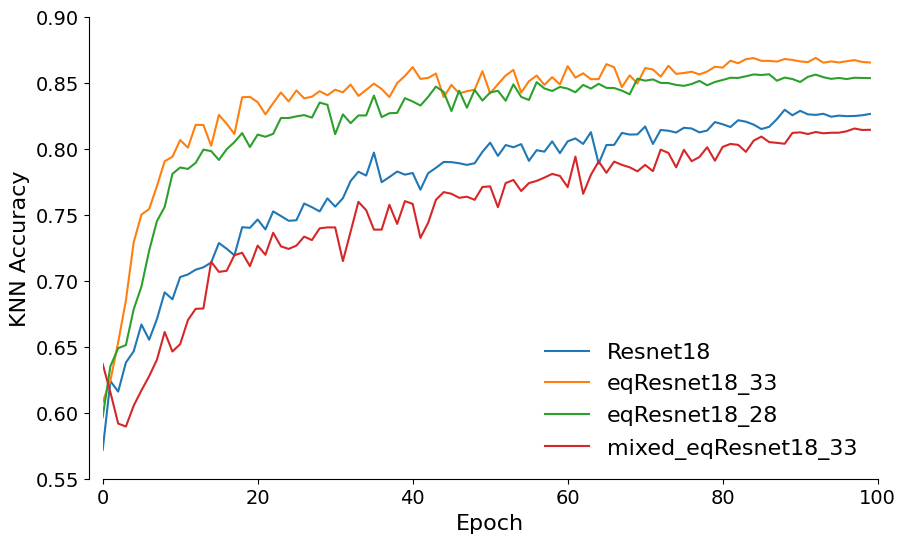

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

size = 16

for model in KNN_training:
    knn_accuracies = KNN_training[model]
    ax.plot(range(0, len(knn_accuracies)), knn_accuracies, label=model)

ax.set_ylim(0.55, 0.9)
ax.set_xlim(0,100)
ax.tick_params(axis='both', which='major', labelsize=size-2)
ax.spines['left'].set_position(('outward', 10)) 

ax.set_xlabel("Epoch", fontsize=size)
ax.set_ylabel("KNN Accuracy", fontsize=size)
ax.legend(frameon=False, fontsize=size)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# t-SNE

In [21]:
list_h_eq = []
list_h_res = []
labels_list = []

test_loader = DataLoader(pmnist_test, batch_size=128, shuffle=False)


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        h_eq, _ = model_eq_n8(images)
        h_res, _ = model_resnet18(images) 

        list_h_eq.append(h_eq.cpu())
        list_h_res.append(h_res.cpu())
        labels_list.append(labels)

all_h_eq = torch.cat(list_h_eq, dim=0).numpy()
all_h_res = torch.cat(list_h_res, dim=0).numpy()
all_labels = torch.cat(labels_list, dim=0).numpy()

In [22]:
from openTSNE import TSNE

tsne_eq = TSNE()
eq_emb = tsne_eq.fit(all_h_eq)

tsne_res = TSNE()
res_emb = tsne_res.fit(all_h_res)

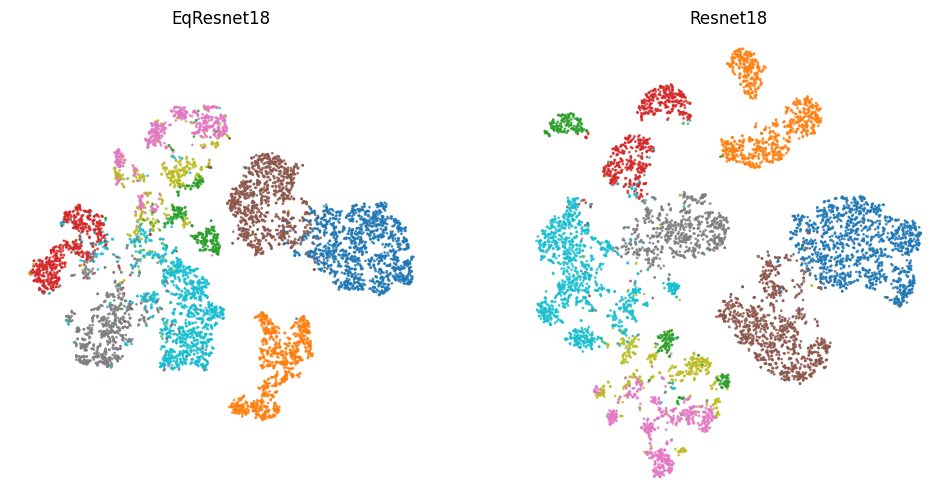

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# EqCLR plot
scatter_eq = ax[0].scatter(eq_emb[:, 0], eq_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[0].set_title('EqResnet18')

# SimCLR plot
scatter_res = ax[1].scatter(res_emb[:, 0], res_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[1].set_title('Resnet18')

for a in ax:
    a.axis('off')
    a.axis('equal')
